In [244]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
import datashader as ds
import datashader.transfer_functions as tf
from datashader.utils import export_image
from collections import OrderedDict as odict
import warnings
import datetime
import numpy as np
from scipy import stats



warnings.filterwarnings("ignore", category=FutureWarning)

In [245]:
df = pd.read_csv('data_synth_train.csv')

In [246]:
df['timestamp'] = pd.to_datetime(df['timestamp'])

In [247]:
# Estrai ore e minuti e convertili in un numero totale di minuti
df['timestamp_in_seconds'] = df['timestamp'].dt.hour * 3600 + df['timestamp'].dt.minute * 60 + df['timestamp'].dt.second

In [248]:
df_melted = df.melt(id_vars=['timestamp_in_seconds'], value_vars=["Living room","Bedroom","Bathroom","Kitchen","Hallway"],
                    var_name='feature', value_name='value')

In [249]:
df_melted

,timestamp_in_seconds,feature,value
0,7,Living room,0
1,27,Living room,0
2,47,Living room,1
3,67,Living room,1
4,87,Living room,1
...,...,...,...
1522835,13903,Hallway,0
1522836,13923,Hallway,0
1522837,13943,Hallway,0
1522838,13963,Hallway,0


In [250]:
df_filtered = df_melted[df_melted['value'] == 1]

In [251]:
df.loc[:, ["temperature","humidity","CO2CosIRValue","CO2MG811Value","MOX1","MOX2","MOX3","MOX4","COValue"]].values.T

array([[ 21.26,  21.19,  21.11, ...,  22.09,  22.04,  21.97],
       [ 57.74,  58.03,  57.53, ...,  55.12,  55.22,  55.22],
       [109.  , 107.  , 107.  , ..., 101.  , 101.  , 100.  ],
       ...,
       [659.  , 658.  , 656.  , ..., 651.  , 651.  , 651.  ],
       [600.  , 603.  , 596.  , ..., 584.  , 585.  , 584.  ],
       [122.  , 122.  , 121.  , ..., 109.  , 108.  , 109.  ]])

In [252]:
df["temperature"].max()

26.52

In [253]:
kde = stats.gaussian_kde(df.loc[:, ["temperature","humidity","CO2CosIRValue","CO2MG811Value","MOX1","MOX2","MOX3","MOX4","COValue"]].values.T)


def prob_E(obs):
    return kde(obs)

def prob_F(label):
    total_observations = len(df)
    combination_count = df[(df["Living room"] == label[0]) 
                           & (df["Bedroom"] == label[1]) 
                           & (df["Bathroom"] == label[2])
                           & (df["Kitchen"] == label[3])
                           & (df["Hallway"] == label[4])].shape[0]
    

    probability = combination_count / total_observations

    return probability


In [87]:
#df['MOX4'].hist(bins = 400)



array([0.])

In [86]:
kde

In [47]:
print(df_filtered[(df_filtered['feature'] == 'Kitchen') * 
                (df_filtered['timestamp_in_seconds'] >= 44700) * 
                (df_filtered['timestamp_in_seconds'] <= 45300)])


len(df[(df['timestamp_in_seconds'] >= 44700) * 
        (df['timestamp_in_seconds'] <= 45300)].index)

         timestamp_in_seconds  feature  value
924586                  44846  Kitchen      1
924587                  44866  Kitchen      1
924588                  44886  Kitchen      1
928899                  44706  Kitchen      1
928900                  44726  Kitchen      1
...                       ...      ...    ...
1215519                 45129  Kitchen      1
1215520                 45149  Kitchen      1
1215524                 45229  Kitchen      1
1215526                 45269  Kitchen      1
1215527                 45289  Kitchen      1

[509 rows x 3 columns]


2135

Definiamo la probabilità P(S = s | T = t) che l'anziano si trovi in una stanza $s \in \{Living room,Bedroom,Bathroom,Kitchen,Hallway\}$, $t \in \{1, 2, \dots, 24 \cdot 3600\}$ in senso frequentista, vale a dire come il rapporto tra il numero di volte in cui tale eventualità si è verificato (magari, anche in timesteps limitrofi) sul totale.

In [42]:
444/10653

0.0416784004505773

/home/fabio/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


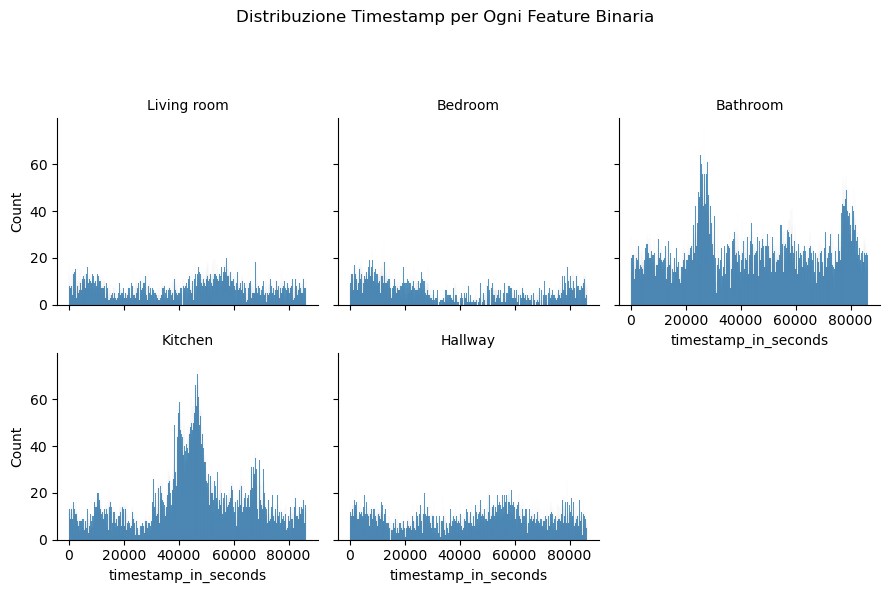

<Figure size 640x480 with 0 Axes>

In [33]:
g = seaborn.FacetGrid(df_filtered, col='feature', col_wrap=3)  # 'col_wrap' per controllare quante colonne per riga

# Mappa l'istogramma all'ora e minuto per ogni feature
g.map(seaborn.histplot, 'timestamp_in_seconds', bins = 1500)

# Regola l'aspetto dei grafici
g.set_titles("{col_name}")
g.fig.subplots_adjust(top=0.8)
g.fig.suptitle('Distribuzione Timestamp per Ogni Feature Binaria')

plt.show()


plt.savefig('Distr_temp.png')

In [8]:
df['day'] = df['timestamp'].dt.date

pippo = list(df['day'].unique())

mapping = {i : pippo.index(i) + 1 for i in pippo}


df['var_CO2CosIRValue'] = df['CO2CosIRValue'].pct_change().fillna(0)
df['var_CO2MG811Value'] = df['CO2MG811Value'].pct_change().fillna(0)
df['var_MOX1'] = df['MOX1'].pct_change().fillna(0)
df['varMOX2'] = df['MOX2'].pct_change().fillna(0)
df['var_MOX3'] = df['MOX3'].pct_change().fillna(0)
df['var_MOX4'] = df['MOX4'].pct_change().fillna(0)
df['var_COValue'] = df['COValue'].pct_change().fillna(0)
df['var_temperature'] = df['temperature'].pct_change().fillna(0)
df['var_humidity'] = df['humidity'].pct_change().fillna(0)


df = df.drop(["temperature","humidity","CO2CosIRValue","CO2MG811Value","MOX1","MOX2","MOX3","MOX4","COValue"], axis = 1)



In [9]:
#df['mapping_day'] = mapping[df['date']]

df['mapped_date'] = (df['day'].map(mapping))

c = ["Living room","Bedroom","Bathroom","Kitchen","Hallway"]
c_ = ["Bathroom","Kitchen"]


In [15]:
df = df.drop(["timestamp", "day"], axis = 1)

In [24]:
df.to_csv('clean_data.csv')

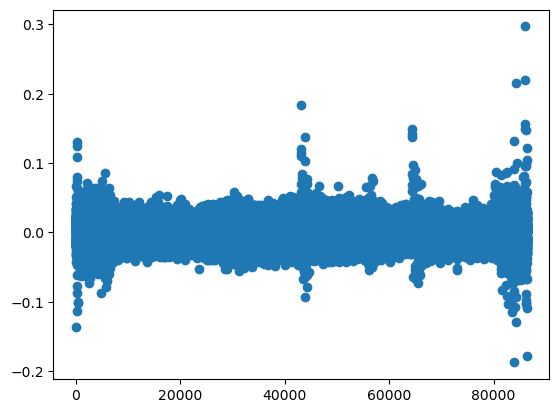

In [23]:
plt.scatter(df['timestamp_in_seconds'].values, df['var_COValue'].values)

In [11]:
to_drop = set()
for i in c_:

   B = df[df[i] == 1].groupby('mapped_date').count()

   dati = B['timestamp'].values

   Q1 = np.percentile(dati, 25)
   Q3 = np.percentile(dati, 75)
   IQR = Q3 - Q1

   # Definizione degli outlier come valori al di fuori di Q1 - 1.5*IQR e Q3 + 1.5*IQR
   outlier_condition = ((dati > (Q3 + 1.8 * IQR)))

   # Recupero degli outlier
   outliers = dati[outlier_condition]

   td = []
   for ol in outliers:
      for j in B[B['timestamp'] == ol].index:
         td.append(j)



   to_drop = to_drop.union(set(td))



In [12]:
td

[3, 8, 11, 34, 36, 49, 53, 57, 59]

In [13]:
# Rimozione degli outliers

df = df[~df['mapped_date'].isin(td)]


In [14]:
df

,timestamp,Living room,Bedroom,Bathroom,Kitchen,Hallway,timestamp_in_seconds,day,var_CO2CosIRValue,var_CO2MG811Value,var_MOX1,varMOX2,var_MOX3,var_MOX4,var_COValue,var_temperature,var_humidity,mapped_date
0,2019-11-07 00:00:07,0,0,0,0,0,7,2019-11-07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1
1,2019-11-07 00:00:27,0,0,0,0,0,27,2019-11-07,-0.018349,0.003766,0.010225,0.002837,-0.001517,0.005000,0.000000,-0.003293,0.005023,1
2,2019-11-07 00:00:47,1,0,0,0,0,47,2019-11-07,0.000000,-0.005629,-0.006073,0.001414,-0.003040,-0.011609,-0.008197,-0.003775,-0.008616,1
3,2019-11-07 00:01:07,1,0,0,0,0,67,2019-11-07,-0.009346,0.003774,-0.004073,0.002825,0.000000,0.001678,0.041322,0.000474,0.007127,1
4,2019-11-07 00:01:27,1,0,0,0,0,87,2019-11-07,-0.028302,0.000000,0.002045,-0.007042,0.003049,0.000000,0.031746,-0.002841,0.004142,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
304563,2020-01-17 03:51:43,0,0,0,0,0,13903,2020-01-17,0.000000,0.001890,0.004556,-0.002882,0.001538,0.001718,0.000000,0.001817,0.003636,72
304564,2020-01-17 03:52:03,0,0,0,0,0,13923,2020-01-17,0.019608,-0.001887,0.000000,0.002890,0.000000,0.000000,0.000000,-0.005442,-0.001268,72
304565,2020-01-17 03:52:23,0,0,0,0,0,13943,2020-01-17,-0.028846,0.000000,0.004535,0.000000,0.000000,0.001715,0.009259,0.007296,-0.000181,72
304566,2020-01-17 03:52:43,0,0,0,0,0,13963,2020-01-17,0.000000,0.000000,-0.004515,0.000000,0.000000,0.001712,-0.009174,-0.002263,0.001814,72


In [48]:
num_intervalli = 24

# Creazione dei bin (intervalli) utilizzando pd.cut
# np.linspace genera estremi degli intervalli dal minimo al massimo valore nella colonna di interesse
bins = np.linspace(0, 3600*24, num_intervalli + 1)
df['intervalli'] = pd.cut(df['timestamp_in_seconds'], bins=bins, include_lowest=True, labels=[3600*i for i in range(num_intervalli)])

# Raggruppamento per intervallo e calcolo della media della grandezza di interesse
media_per_intervallo = df.groupby('intervalli')['COValue'].mean().reset_index()


media_per_intervallo

,intervalli,COValue
0,0,117.244876
1,3600,113.150469
2,7200,109.037637
3,10800,105.914523
4,14400,102.964444
5,18000,102.353810
6,21600,101.638571
7,25200,101.032696
8,28800,104.367112
9,32400,107.283957


<Axes: ylabel='Count'>

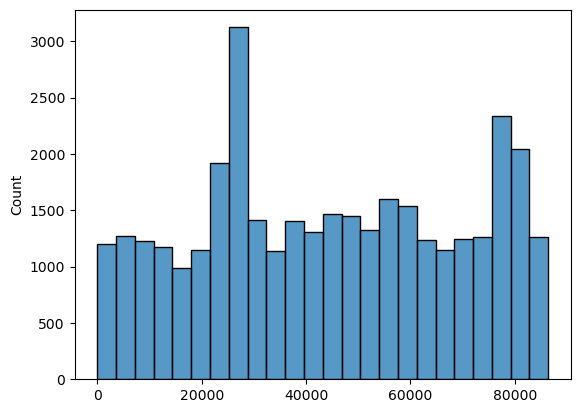

In [50]:
data = df[
        (df[c[2]] == 1)]['hour_minute']





seaborn.histplot(data.values, bins = 24)




In [89]:
df

,timestamp,temperature,humidity,CO2CosIRValue,CO2MG811Value,MOX1,MOX2,MOX3,MOX4,COValue,Living room,Bedroom,Bathroom,Kitchen,Hallway,timestamp_in_seconds
0,2019-11-07 00:00:07,21.26,57.74,109,531,489,705,659,600,122,0,0,0,0,0,7
1,2019-11-07 00:00:27,21.19,58.03,107,533,494,707,658,603,122,0,0,0,0,0,27
2,2019-11-07 00:00:47,21.11,57.53,107,530,491,708,656,596,121,1,0,0,0,0,47
3,2019-11-07 00:01:07,21.12,57.94,106,532,489,710,656,597,126,1,0,0,0,0,67
4,2019-11-07 00:01:27,21.06,58.18,103,532,490,705,658,597,130,1,0,0,0,0,87
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
304563,2020-01-17 03:51:43,22.05,55.20,102,530,441,692,651,583,108,0,0,0,0,0,13903
304564,2020-01-17 03:52:03,21.93,55.13,104,529,441,694,651,583,108,0,0,0,0,0,13923
304565,2020-01-17 03:52:23,22.09,55.12,101,529,443,694,651,584,109,0,0,0,0,0,13943
304566,2020-01-17 03:52:43,22.04,55.22,101,529,441,694,651,585,108,0,0,0,0,0,13963


In [218]:
df_prova = df[~ ((df['Bathroom']==0) *
                 (df['Bedroom']==0) *
                 (df['Hallway']==0) *
                 (df['Living room']==0) *
                 (df['Kitchen']==0))]


df_1 = df[(df['timestamp_in_seconds'] >= 8*3600) * (df['timestamp_in_seconds'] <= 23*3600)]

In [260]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split






rooms = ["Living room","Bedroom","Bathroom","Kitchen","Hallway"]
models = {i:None for i in rooms}



# Divisione del dataset in set di addestramento e di test


for room in rooms:
    X, y = df.loc[:, ["timestamp_in_seconds", "temperature", "humidity",
                  "CO2CosIRValue","CO2MG811Value","MOX1",
                  "MOX2","MOX3","MOX4","COValue"]] , df.loc[:, room]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Inizializza il classificatore Random Forest
    models[room] = RandomForestClassifier(n_estimators=100, random_state=42)

    # Addestra il modello sui dati di training
    #model = GaussianNB()
    models[room].fit(X_train, y_train)

    # Predizione sul set di test
    y_pred = models[room].predict(X_test)

    # Valutazione del modello
    accuracy = f1_score(y_test, y_pred)
    print(f"Accuracy del modello: {accuracy}")

Accuracy del modello: 0.5997300944669366
Accuracy del modello: 0.5649218218898708
Accuracy del modello: 0.73140562248996
Accuracy del modello: 0.8216528760841392
Accuracy del modello: 0.6013926988816206


In [315]:
for room in rooms:

    X, y = df.loc[:, ["timestamp_in_seconds", "temperature", "humidity",
                  "CO2CosIRValue","CO2MG811Value","MOX1",
                  "MOX2","MOX3","MOX4","COValue"]] , df.loc[:, room]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    y_pred = models[room].predict(X_test)

    # Valutazione del modello
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy del modello: {accuracy}")

Accuracy del modello: 0.9756542010046951
Accuracy del modello: 0.9789867682306203
Accuracy del modello: 0.9451029320024953
Accuracy del modello: 0.9706307252848277
Accuracy del modello: 0.968989066552845


In [316]:
(0.9756542010046951 + 0.9789867682306203 + 0.9451029320024953 + 0.9706307252848277 + 0.968989066552845) / 5


0.9678727386150966

In [305]:
df_test = pd.read_csv('data_synth_test.csv')

df_test['timestamp'] = pd.to_datetime(df_test['timestamp'])

df_test['timestamp_in_seconds'] = df_test['timestamp'].dt.hour * 3600 + df_test['timestamp'].dt.minute * 60 + df_test['timestamp'].dt.second


In [306]:
df_test

,timestamp,temperature,humidity,CO2CosIRValue,CO2MG811Value,MOX1,MOX2,MOX3,MOX4,COValue,timestamp_in_seconds
0,2020-01-17 03:53:23,21.98,55.12,102,530,444,695,652,586,109,14003
1,2020-01-17 03:53:43,22.08,55.07,102,529,444,696,650,585,107,14023
2,2020-01-17 03:54:03,22.14,55.13,102,528,442,694,651,583,108,14043
3,2020-01-17 03:54:23,22.07,55.21,102,529,442,694,651,585,108,14063
4,2020-01-17 03:54:43,22.03,55.07,101,530,443,694,651,583,108,14083
...,...,...,...,...,...,...,...,...,...,...,...
64076,2020-01-31 23:58:37,22.85,52.94,073,535,467,691,647,572,129,86317
64077,2020-01-31 23:58:57,22.79,52.99,072,535,467,691,646,572,129,86337
64078,2020-01-31 23:59:17,22.74,53.05,072,535,467,691,646,572,129,86357
64079,2020-01-31 23:59:37,22.71,53.42,073,535,467,691,646,572,128,86377


In [307]:
df_test.replace('     ', np.nan, inplace=True)
df_test.replace('   ', np.nan, inplace=True)

# Applicazione del forward fill
df_test.ffill(inplace=True)

In [308]:

X_testolone = df_test.loc[:, ["timestamp_in_seconds", "temperature", "humidity",
                  "CO2CosIRValue","CO2MG811Value","MOX1",
                  "MOX2","MOX3","MOX4","COValue"]].values.astype(np.float64)

In [310]:
df_test['Living room'] = models['Living room'].predict_proba(X_testolone)[:, 1]

df_test['Bedroom'] = models['Bedroom'].predict_proba(X_testolone)[:, 1]

df_test['Bathroom'] = models['Bathroom'].predict_proba(X_testolone)[:, 1]

df_test['Kitchen'] = models['Kitchen'].predict_proba(X_testolone)[:, 1]

df_test['Hallway'] = models['Hallway'].predict_proba(X_testolone)[:, 1]

/home/fabio/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/fabio/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/fabio/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/fabio/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/fabio/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [312]:
df_test = df_test.drop('timestamp_in_seconds', axis=1)

df_test

,timestamp,temperature,humidity,CO2CosIRValue,CO2MG811Value,MOX1,MOX2,MOX3,MOX4,COValue,Living room,Bedroom,Bathroom,Kitchen,Hallway
0,2020-01-17 03:53:23,21.98,55.12,102,530,444,695,652,586,109,0.00,0.00,0.00,0.01,0.00
1,2020-01-17 03:53:43,22.08,55.07,102,529,444,696,650,585,107,0.00,0.00,0.00,0.02,0.01
2,2020-01-17 03:54:03,22.14,55.13,102,528,442,694,651,583,108,0.00,0.00,0.00,0.00,0.00
3,2020-01-17 03:54:23,22.07,55.21,102,529,442,694,651,585,108,0.00,0.01,0.00,0.00,0.00
4,2020-01-17 03:54:43,22.03,55.07,101,530,443,694,651,583,108,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64076,2020-01-31 23:58:37,22.85,52.94,073,535,467,691,647,572,129,0.04,0.06,0.11,0.08,0.07
64077,2020-01-31 23:58:57,22.79,52.99,072,535,467,691,646,572,129,0.02,0.05,0.14,0.07,0.10
64078,2020-01-31 23:59:17,22.74,53.05,072,535,467,691,646,572,129,0.02,0.05,0.15,0.07,0.10
64079,2020-01-31 23:59:37,22.71,53.42,073,535,467,691,646,572,128,0.08,0.05,0.14,0.08,0.09


In [313]:
df_test.to_csv('BinaryBrilliance.csv')

/home/fabio/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


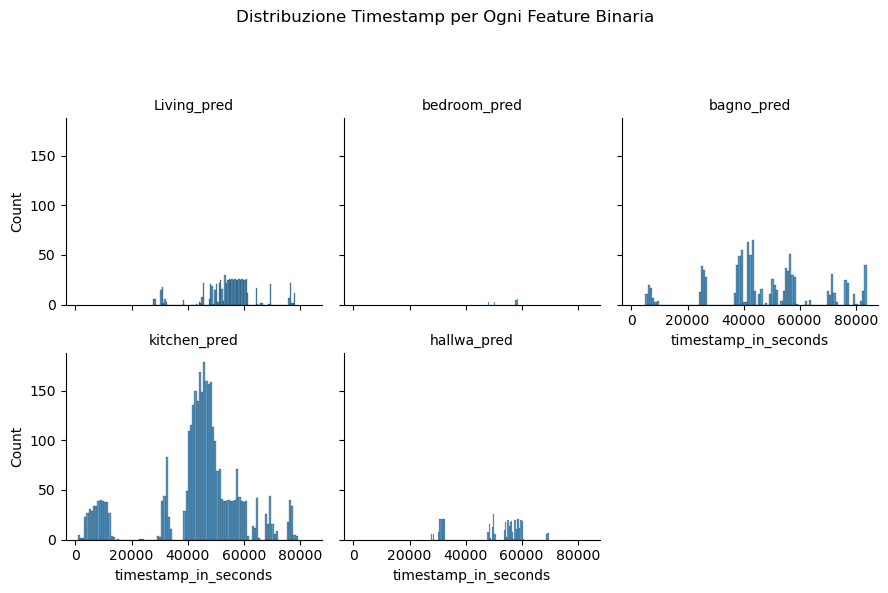

<Figure size 640x480 with 0 Axes>

In [300]:
df_melted = df_test.melt(id_vars=['timestamp_in_seconds'], value_vars=["Living_pred","bedroom_pred","bagno_pred","kitchen_pred","hallwa_pred"],
                    var_name='feature', value_name='value')


df_filtered = df_melted[df_melted['value'] == 1]

g = seaborn.FacetGrid(df_filtered, col='feature', col_wrap=3)  # 'col_wrap' per controllare quante colonne per riga

# Mappa l'istogramma all'ora e minuto per ogni feature
g.map(seaborn.histplot, 'timestamp_in_seconds', bins = 100)

# Regola l'aspetto dei grafici
g.set_titles("{col_name}")
g.fig.subplots_adjust(top=0.8)
g.fig.suptitle('Distribuzione Timestamp per Ogni Feature Binaria')

plt.show()


plt.savefig('Distr_temp.png')

In [257]:
model.predict_proba(X_test)

array([[1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       ...,
       [1.  , 0.  ],
       [1.  , 0.  ],
       [0.99, 0.01]])

In [258]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, y_pred)


array([[55004,   485],
       [ 1304,  4121]])

In [166]:
from sklearn.metrics import confusion_matrix


confusion_matrix(y_test, y_pred)


array([[55488,  3562],
       [ 1159,   705]])